# Practica 2: Recurrent Neural Network (RNN))


En esta segunda parte de la practica 2 vamos a implementar una RNN usando Keras para la estimación de valores en una serie de tiempo.

Una red neuronal recurrente (RNN) es un tipo de red neuronal diseñada para procesar datos secuenciales, es decir, datos en los que el orden de los elementos es importante, como texto o series temporales. A diferencia de las redes neuronales estándar, que tratan cada entrada de forma independiente, las RNN tienen una "memoria" que les permite incorporar información de entradas anteriores en su procesamiento de las entradas actuales. Esto las hace idóneas para tareas como la traducción de idiomas, el reconocimiento de voz y la predicción de series temporales.

**Datos secuenciales:**

Las RNN están diseñadas específicamente para manejar datos en los que el orden de los elementos es crucial. Los ejemplos incluyen:

*   Texto: Las palabras de una frase tienen un orden específico que afecta al significado.
*   Series temporales: Puntos de datos recogidos a lo largo del tiempo, como los precios de las acciones o los datos meteorológicos, en los que los valores pasados influyen en los valores futuros.

**Memoria:**
A diferencia de las redes feedforward, las RNN tienen bucles que permiten pasar información de un paso de la secuencia al siguiente, creando una especie de «memoria».
Funcionamiento:

*   En cada paso de la secuencia, la RNN toma como entrada la información actual y el «estado oculto» (que contiene información de pasos anteriores).
*   A continuación, procesa estas entradas para producir una salida y actualiza el estado oculto para el siguiente paso.
*   Esto permite a la red «recordar» información pasada y utilizarla para influir en el procesamiento de la entrada actual.

**Aplicaciones:**

*   Procesamiento del lenguaje natural (PLN): Traducción de idiomas, análisis de sentimientos, generación de textos, reconocimiento de voz.
*   Análisis de series temporales: Predicción de cotizaciones bursátiles, patrones meteorológicos y otros datos dependientes del tiempo.
*   Otras tareas de datos secuenciales: Análisis de vídeo, generación de música.



### Importar librerias



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2025-07-05 09:17:38.501038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751725058.521641   24460 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751725058.527808   24460 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751725058.546512   24460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751725058.546530   24460 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751725058.546532   24460 computation_placer.cc:177] computation placer alr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# Configurar uso de GPU (si está disponible)
if gpus:
	try:
		# Configurar límite de memoria GPU
		tf.config.experimental.set_memory_growth(gpus[0], False)
		# Establecer límite de memoria (por ejemplo, 4096 MB)
		tf.config.experimental.set_virtual_device_configuration(
			gpus[0],
			[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
		)
		print("TensorFlow configurado para usar memoria GPU completa (1024 MB).")
	except RuntimeError as e:
		print(e)
else:
	print("No se detectaron GPUs.")

TensorFlow configurado para usar memoria GPU completa (1024 MB).


##Cargar datos
Primero vamos a cargar una serie de tiempo que se encuentra en el archivo monthly-sunspots.csv.

El archivo «monthly-sunspots.csv» contiene datos mensuales de manchas solares, que es una serie temporal del número de manchas solares observadas cada mes. Las manchas solares son fenómenos temporales en la fotosfera del Sol que aparecen como manchas más oscuras que las zonas circundantes. Son regiones de temperatura superficial reducida causada por concentraciones de flujo de campo magnético que inhiben la convección.

In [4]:
#Leer datos (solo la segunda columna) en formato float32
##
data = pd.read_csv('monthly-sunspots.csv', usecols=[1], engine='python', dtype=np.float32)
data = np.array(data)
#Scalar los datos de 0 a 1 y obtener un arreglo de 1d
##
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Dividir los datos en entrenamiento (80%) y prueba (20%)
##
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

(2820, 1)


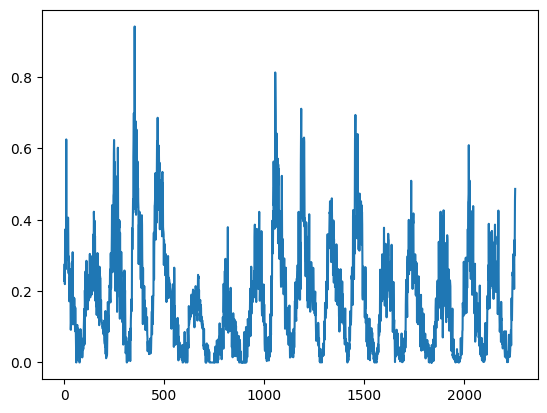

In [5]:
	#Visualizar datos de entrenamiento
##
print(data.shape)
plt.plot(train_data)

(564, 1)


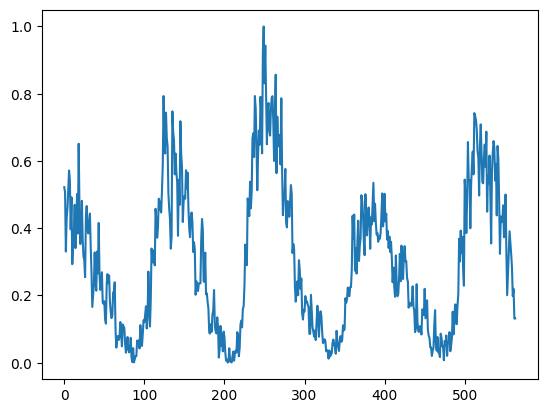

In [6]:
#Visualizar datos de prueba
##
print(test_data.shape)
plt.plot(test_data)

## Preparación de datos para entrenamiento
El siguiente paso es preparar los datos para el entrenamiento del modelo Keras. El array de entrada debe tener la siguiente forma: total_samples x time_steps x features.

Hay muchas formas de preparar los datos de series temporales para el entrenamiento. Crearemos filas de entrada con pasos de tiempo no solapados.

Un ejemplo para time_steps = 2 sería:

Entrada:

x = [(0,10), (20,30), (40,50)]

t = [(0, 1), ( 2, 3), ( 4, 5)]

Salida:

y = [   20,      40,       60]

t = [    2,       4,        6]

Aquí, time_steps denota el número de pasos de tiempo anteriores a utilizar para predecir el siguiente valor de los datos de series temporales.

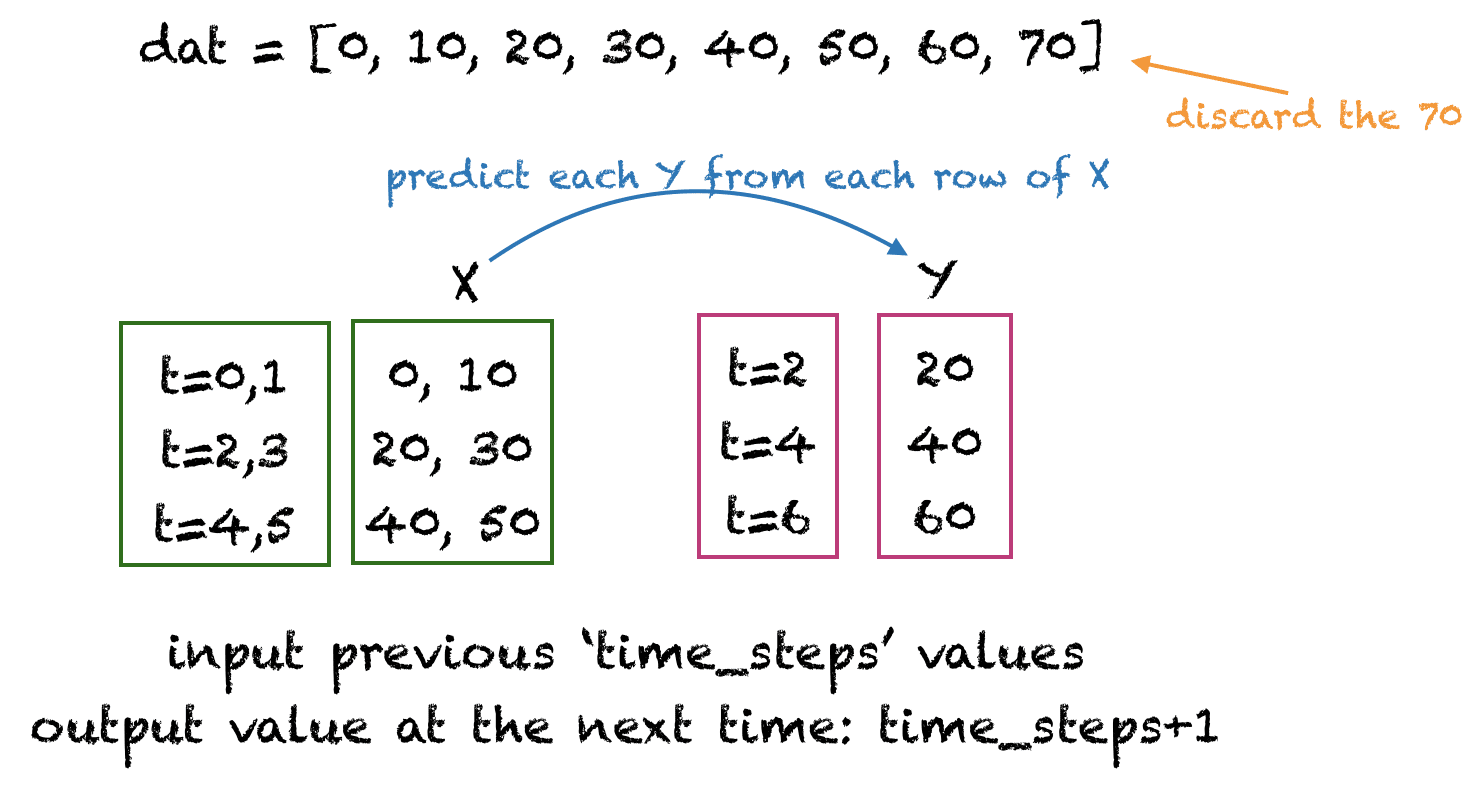

La siguiente función permitira construir estos arreglos. Recibiendo los datos y el time_steps. La salida de la función son los vectores X y Y, donde Y es el valor a estimar mediante la red.

*   Usaremos el metodo np.arange(start, stop, step) para generar los indices entre [start, stop) espaciados por time_steps
*   El total de muestras será los datos disponibles / time_steps



In [10]:
#Metodo para construir los conjuntos X y Y de entrenamiento y prueba
def get_XY(dat, time_steps):
	# Indices del arreglo Y
	Y_ind = np.arange(time_steps, len(dat), time_steps)
	# Arreglo de los valores a estimar
	Y = dat[Y_ind]
	# Organización de X en un arreglo de
	# total_samples x time_steps x features
	rows_x = len(Y_ind)
	X = dat[range(rows_x * time_steps)].reshape(rows_x, time_steps, 1)
	return X, Y

#Usaremos un time_steps de 12 meses
time_steps = 12
#Organizamos los datos de entrenamiento
trainX, trainY = get_XY(train_data, time_steps)
#Organizamos los datos de prueba
testX, testY = get_XY(test_data, time_steps)


In [11]:
#Revisamos las dimensiones de los conjuntos
#Datos de entrenamiento
print("Datos de entrenamiento: ")
print("X: ", trainX.shape)
print("Y: ", trainY.shape)

Datos de entrenamiento: 
X:  (187, 12, 1)
Y:  (187, 1)


In [12]:
#Datos de prueba
print("Datos de prueba: ")
print("X: ", testX.shape)
print("Y: ", testY.shape)

Datos de prueba: 
X:  (46, 12, 1)
Y:  (46, 1)


Nota: en este ejemplo estamos usando 12 muestras en el tiempo para estimar un valor de mancha solar.

##Construcción del modelo RNN
Vamos a emplear el modelo secuencial con una RNN, utilizaremos un arquitectura sencilla:


*   Una capa RNN con 3 neuronas ocultas
*   Una capa RNN de salida con 1 neurona para predecir el valor
*   Usaremos la función de activación tanh
*   Asegúrese de establecer return_sequences=True para todas las capas recurrentes (excepto la última, si sólo le interesa la última salida). Sino, la salida será un arreglo 2D (solo con la salida del ultimo paso) en vez de un arreglo 3D (con las salidas de TODOS los pasos). Esto genera un error en las siguientes capas.

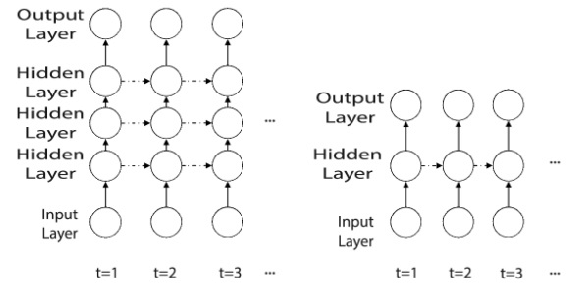


In [13]:
#Importar librerias
from keras.models import Sequential
from keras.layers import SimpleRNN

In [19]:
#Configurar el modelo
model = Sequential()
#Capa RNN con 3 neuronas
model.add(SimpleRNN(3, input_shape=(time_steps, 1), activation='tanh', return_sequences=True))

#Capa RNN con 1 neurona
model.add(SimpleRNN(1, activation='tanh', return_sequences=False))


/home/ezapataq/GitHub/AnalyticsMaster/MachineLearning/Workshops/W2/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
#Exploración de la arquitectura
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 12, 3)          │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

##Entrenamiento del modelo

In [21]:
#Parametros para entrenamiento
epochs = 100
batch_size = 1

#Entrenamiento
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)


Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3860
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0418
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0274
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0156
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097
Epoch 12/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089
Epoch 13/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089
Epoch 14/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0071
Epoch 15/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1

##Predicciones con el modelo

In [22]:
# Aplicar el modelo a datos de prueba

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


##Metricas de desempeño

In [23]:
# Vamos a usar las mismas metricas de la practica 1
from sklearn import metrics

print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

MSE:  0.00677590724080801
RMSE:  0.08231589907671549
MAE:  0.06180630996823311
R2_score:  0.853181004524231


##Visualización del resultado

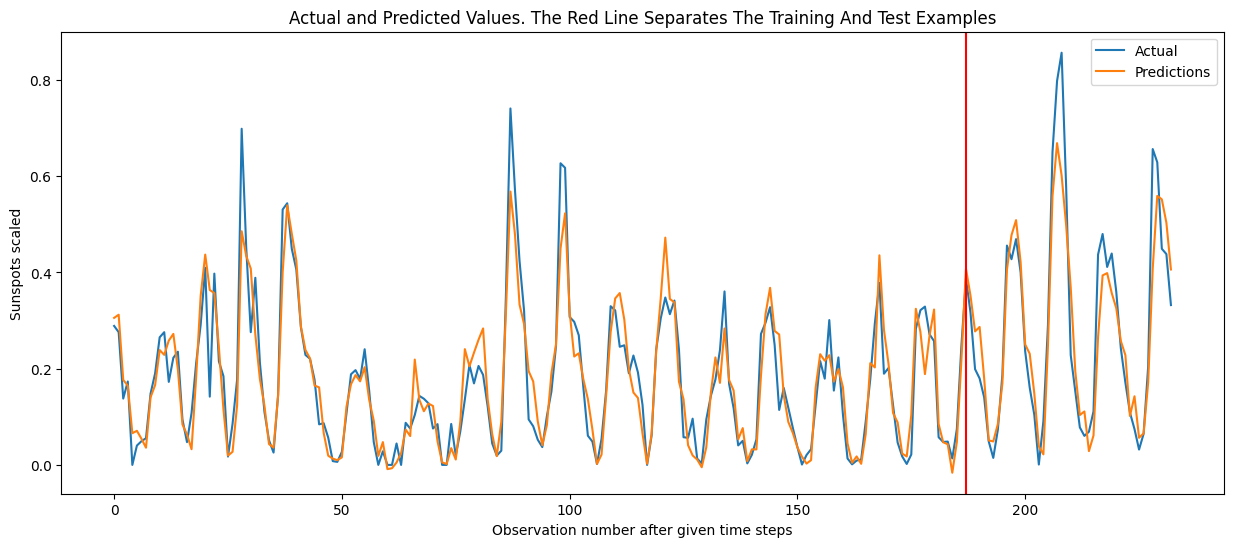

In [27]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=100)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)

# Long Short-Term Memory (LSTM)

Una red de memoria a corto plazo (LSTM) es un tipo de red neuronal recurrente (RNN) diseñada específicamente para manejar datos secuenciales y aprender dependencias a largo plazo. A diferencia de las RNN estándar, las LSTM recuerdan mejor la información durante periodos más largos, mitigando el problema del gradiente de fuga que puede dificultar el aprendizaje en las RNN tradicionales. Esto las hace adecuadas para tareas en las que el orden de los datos es importante, como el reconocimiento de voz, la traducción automática y el análisis de series temporales.

**Dependencias a largo plazo:**
Uno de los principales retos de las RNN es el aprendizaje de las dependencias a largo plazo, es decir, la capacidad de relacionar la información desde el principio de una secuencia hasta el final. Las RNN estándar se enfrentan a este reto debido al problema del gradiente evanescente, en el que los gradientes (información sobre cómo ajustar los pesos de la red) se vuelven muy pequeños durante la retropropagación, lo que dificulta el aprendizaje.

**La solución de LSTM:**
Las LSTM solucionan este problema introduciendo una célula de memoria y «gates» que regulan el flujo de información que entra y sale de la célula. Estas puertas, que incluyen puertas de entrada, olvido y salida, determinan selectivamente qué información se almacena, se descarta o se emite en cada paso temporal.

In [28]:
from keras.layers import LSTM

#Importar el modelo


#Configurar el modelo
model = Sequential()
#Capa LSTM con 3 neuronas
model.add(LSTM(3, input_shape=(time_steps, 1), activation='tanh', return_sequences=True))

#Capa LSTM con 1 neurona
model.add(LSTM(1, activation='tanh', return_sequences=False))


/home/ezapataq/GitHub/AnalyticsMaster/MachineLearning/Workshops/W2/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss='mean_squared_error')
#Entrenamiento
history = model.fit(trainX, trainY, epochs=100, batch_size=1)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0480
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0172
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075
Epoch 12/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063
Epoch 13/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049
Epoch 14/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 15/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1

In [30]:
#Desempeño
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MSE:  0.006495496723800898
RMSE:  0.0805946445106677
MAE:  0.05612190440297127
R2_score:  0.8592569231987


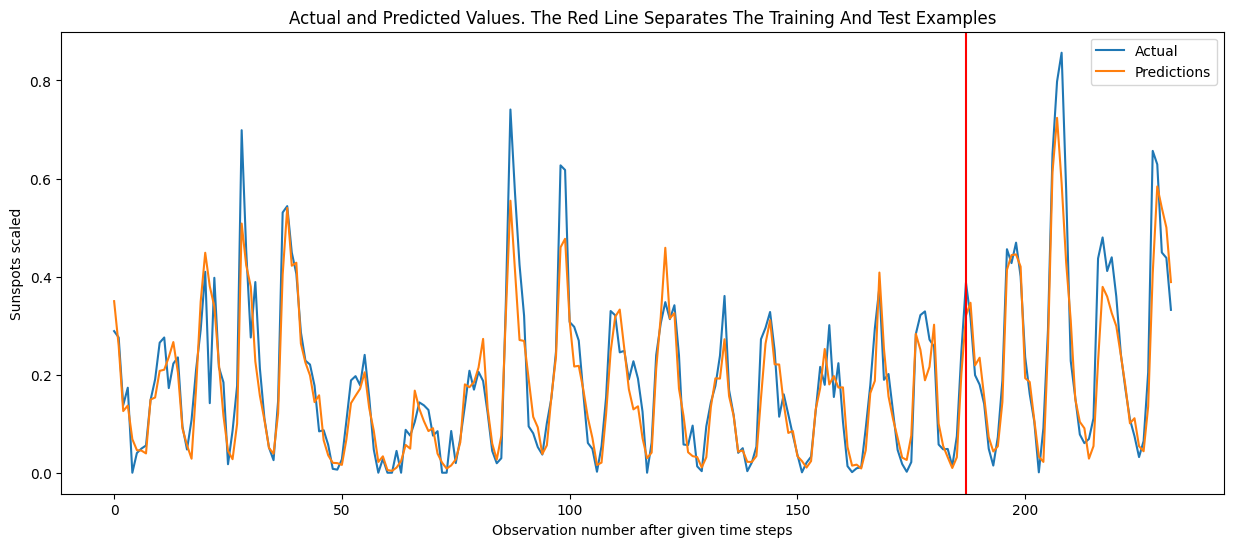

In [31]:
plot_result(trainY, testY, train_predict, test_predict)

# ¡Gran trabajo!